# Статистический анализ данных сервиса аренды самокатов

### Цель проекта: проанализировать данные и понять, являются ли пользователи, использующие платную подписку, более выгодными для компании по сравнению с обычными пользователями.

### Описание проекта:

Для того, чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться без подписки (абонентская плата отсутствует; стоимость одной минуты поездки — 8 рублей; стоимость старта (начала поездки) — 50 рублей) или с подпиской Ultra (абонентская плата — 199 рублей в месяц; стоимость одной минуты поездки — 6 рублей; бесплатная стоимость старта).

В выборке представлены данные о 1565 пользователях: их id, имена, возраст, город, какой подпиской они пользуются, а также информация об их поездках (расстояние, которое пользователь проехал в текущей сессии, продолжительность и дата совершения поездки).

Необходимо объединить эти данные, посчитать объем помесячной выручки с каждого пользователя и проверить следующие гипотезы:

   - Тратят ли пользователи с подпиской больше времени на поездки?
   - Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
   - Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?


### План работы:

1. Загрузка датасетов, получение общей информации о каждом наборе данных.
2. Предобработка данных: устранение недостатков в данных, создание столбца с номерос месяца на основе столбца date.
3. Исследовательский анализ данных: описание и визуализация общей информации о пользователях и поездках.
4. Объединение данных о пользователях, поездках и подписках в один датафрейм, создание двух наборов данных из полученного датафрейма с данными о пользователях каждой категории (с платной подпиской и без).
5. Подсчёт помесячной выручки, которую принес каждый пользователь, на основании полученных ранее наборов данных. 
6. Проверка гипотез.
7. Итоговый вывод.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from math import factorial

#### Шаг 1. Загрузка данных

In [2]:
# Загружаем данные из файлов в датафреймы
try:
    users_data = pd.read_csv('Downloads/users_go.csv')
    rides_data = pd.read_csv('Downloads/rides_go.csv')
    subs_data = pd.read_csv('Downloads/subscriptions_go.csv')
    
except:
    users_data = pd.read_csv('https://code.s3.yandex.net/datasets//users_go.csv')
    rides_data = pd.read_csv('https://code.s3.yandex.net/datasets//rides_go.csv')
    subs_data = pd.read_csv('https://code.s3.yandex.net/datasets//subscriptions_go.csv')

In [3]:
# Изучаем общую информацию о датафрейме users_data
display(users_data.info())
display(users_data.head(5))
print(users_data.isna().sum())
print(users_data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
31


Датасет содержит 1534 строки, 5 столбцов. Дубликаты были выявлены в количестве 31, пропусков не обнаружено. 

In [4]:
# Изучаем общую информацию о датафрейме rides_data
display(rides_data.info())
display(rides_data.head(5))
print(rides_data.isna().sum())
print(rides_data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


user_id     0
distance    0
duration    0
date        0
dtype: int64
0


В датасете 18068 строк, 4 столбца. Пропуски и дубликаты отсутствуют. Тип данных, содержащихся в столбце 'date' следует приветси к типу datetime

In [5]:
# Изучаем общую информацию о датафрейме subs_data
display(subs_data.info())
display(subs_data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


В датасете всего две строки, которые содержат информацию о каждом из двух тарифов - без подписки и с подпиской Ultra. Пропуски и дубликаты отсутствуют. 

   Вывод:
   
   - В датасете users_data есть дубликаты, от которых следует избавиться;
   - Значения столбца 'date' датасета rides_data следует привети к типу данных datetime;
   - Значения столбца 'duration' датасета rides_data можно округлить до целых и привети к типу данных int. 

#### Шаг 2. Предобработка данных

In [6]:
# Удаляем дубликаты в users_data
users_data = users_data.drop_duplicates().reset_index(drop=True) 
print(users_data.duplicated().sum())

0


In [7]:
# Меняем тип данных столбца date на datetime
rides_data['date'] = pd.to_datetime(rides_data['date'], format = '%Y-%m-%d')

In [8]:
# Округляем значения и меняем тип нанных на целочисленный в столбце duration датасета rides_data
rides_data['duration'] = np.ceil(rides_data['duration']).astype('int')
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  int64         
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 564.8 KB


In [9]:
# В датасете rides_data создаем новый столбец с номером месяца на основе столбца date
rides_data['month'] = rides_data['date'].dt.month
rides_data.head(5)

,user_id,distance,duration,date,month
0,1,4409.919140,26,2021-01-01,1
1,1,2617.592153,16,2021-01-18,1
2,1,754.159807,7,2021-04-20,4
3,1,2694.783254,19,2021-08-11,8
4,1,4028.687306,27,2021-08-28,8


В результате предобработки данных:
   - Устранены дубликаты в датасете users_data;
   - В датасете rides_data типы данных столбцов 'date' и 'duration' изменены на datetime и int соответственно;
   - Создан новый столбцец в датасете rides_data, значения в котором отображают номер месяца поездки.

#### Шаг 3. Исследовательский анализ данных

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

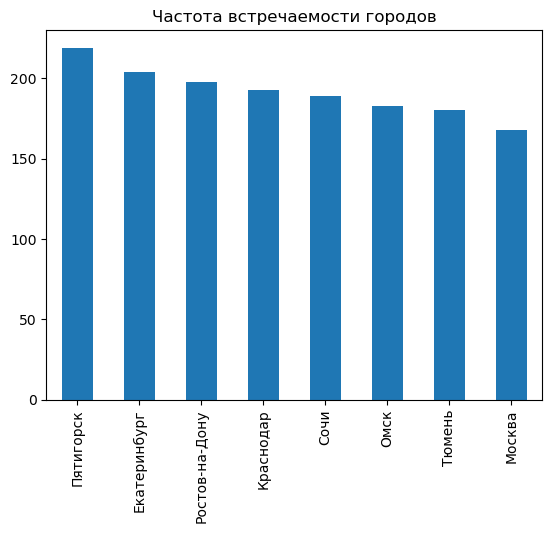

In [10]:
# Проанализируем информацию о частоте встречаемости городов. Для этого построим столбчатую диаграмму
# Выведем таблицу с числовыми значениями частотности городов
top_city = users_data['city'].value_counts().sort_values(ascending = False)
display(top_city)

# Построим график
top_city.plot(kind = 'bar');
plt.title('Частота встречаемости городов')
plt.show()

Как видно на графике, пользователей из Пятигорска больше всего в представленных данных. Меньше всего пользователей из Москвы.

Пользователей без подписки: 835
Пользователей с подпиской: 699


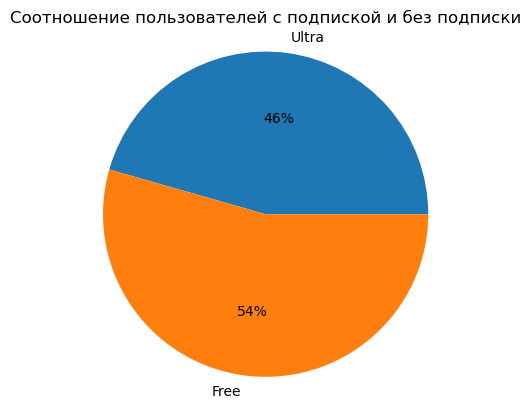

In [11]:
# Исследуем соотношение пользователей с подпиской и без подписки
# Вычислим количество пользователей с подпиской и без подписки

subs = users_data[users_data['subscription_type'] == 'ultra']['subscription_type'].count()
unsubs = users_data[users_data['subscription_type'] == 'free']['subscription_type'].count()
print('Пользователей без подписки:', unsubs)
print('Пользователей с подпиской:', subs)

# Отразим соотношение на круговой диаграмме

subscription_types = [subs, unsubs]
labels = ['Ultra', 'Free']

plt.pie(subscription_types, labels = labels, autopct='%.0f%%', radius = 1.1)
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.show()

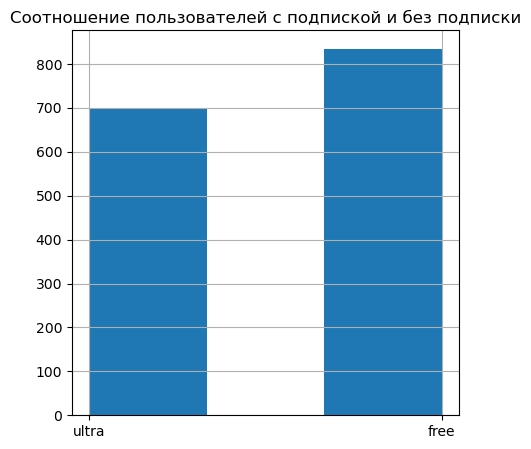

In [12]:
# Построим гистограмму

users_data['subscription_type'].hist(bins = 3, figsize = (5, 5));
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.show()

Вычисления и графики показали, что пользователей без подписки больше, чем пользователей с подпиской на 8%. Пользователей без подписки всего 835, подпиской пользуется 699 пользователей. 

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

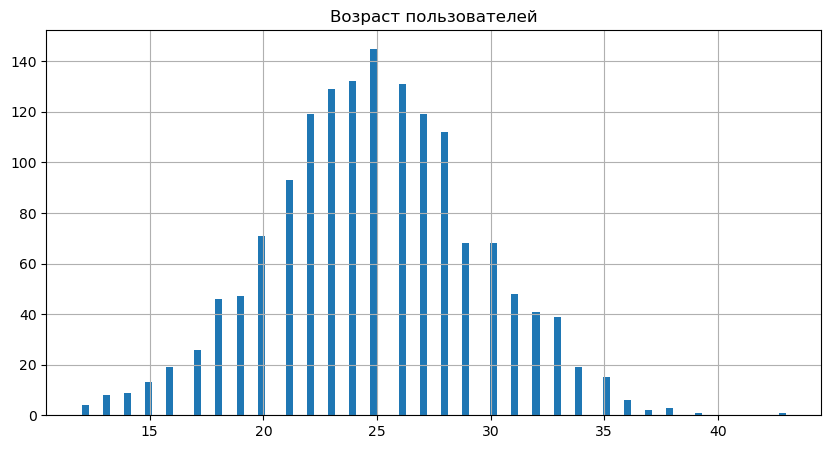

In [13]:
# Исследуем возраст пользователей
display(users_data['age'].describe())
users_data['age'].hist(bins = 100, figsize = (10, 5));
plt.title('Возраст пользователей')
plt.show()

На графике видно, что основная часть данных распределена в диапазоне от 20 до 30 лет, средний возраст пользователей GoFast - 25 лет. Минимальный возраст среди пользователей в представленных данных - 12 лет. Максимальный возраст пользователя - 43 года. 

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

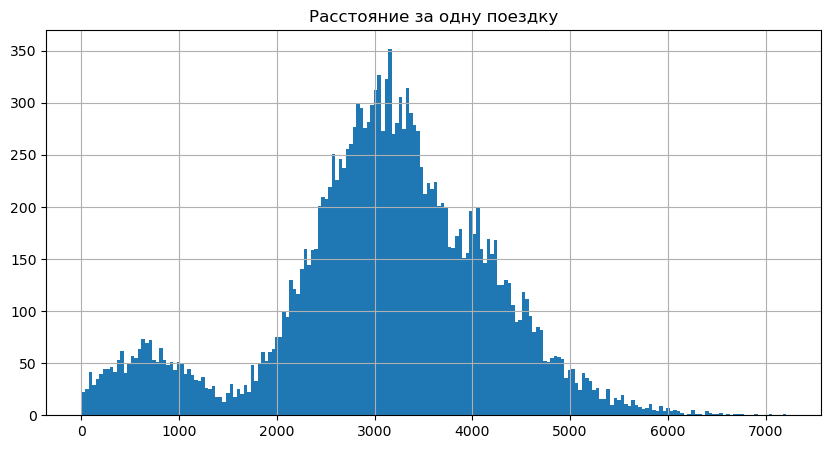

In [14]:
# Исследуем расстояние, которое преодолевает пользователь за одну поездку

display(rides_data['distance'].describe())
rides_data['distance'].hist(bins = 200, figsize = (10, 5));
plt.title('Расстояние за одну поездку')
plt.show()

Судя по графику, поездки можно разделить на короткие (до 1500 м) и длительные (от 1500 м). За одну короткую поездку пользователи проезжают около 750 м, за одну длительную поездку - примерно 3100 м. В среднем пользователи проезжают 3 км за одну поездку. Самое большое расстояние, которое проезжал пользователь равна 7.2 км. 

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

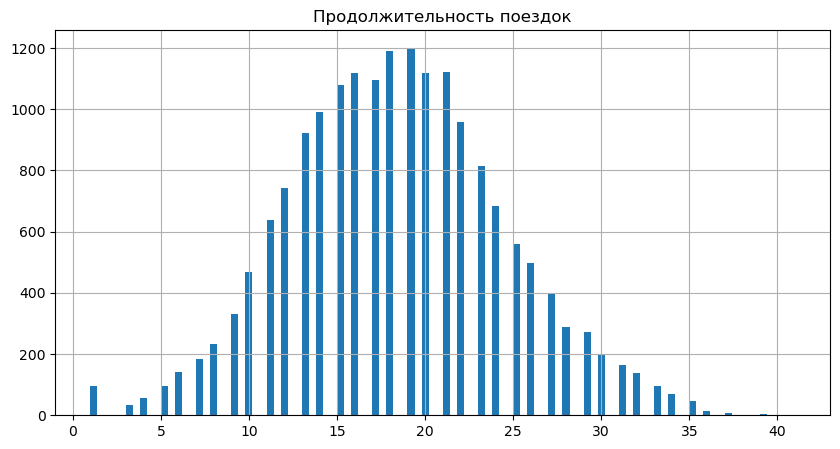

In [15]:
# Исследуем продолжительность поездок

display(rides_data['duration'].describe())
rides_data['duration'].hist(bins = 100, figsize = (10, 5));
plt.title('Продолжительность поездок')
plt.show()

Продолжительность поездки в среднем составляет 18 минут. Самая длительная поездка составила 41 минуту, самая короткая - одну минуту. 

    В результате исследовательского анилиза можно сделать следующие выводы:
       - Аномальных значений и выбросов в данных не обнаружено
       - Визуализация данных позволяет узнать, что:
           а) Больше всего пользователей из Пятигорска;
           б) Пользователей без подписки больше пользователей с подпиской всего на 8%;
           в) Средний возраст пользователей - 25 лет;
           г) Среднее расстояние, которое преодолевает пользователь за поездку, составляет 18 минут;
           д) Продолжительность одной поездки в среднем равна 3 км. 

#### Шаг 4. Объединение данных

In [16]:
# Объединим данные о пользователях, поездках и подписках в один датафрейм
data = users_data.merge(rides_data, on='user_id', how='outer') 
data = data.merge(subs_data, on='subscription_type', how='outer')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  int64         
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(3)
memory usage: 1.8+ MB


In [17]:
data.head(3)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7,2021-04-20,4,6,0,199


Новый датафрейм состоит из 18068 строк и 12 столбцов.

In [18]:
# Создадим два датафрейма с данными о пользователях с подпиской (subs_data) и без подписки (unsubs_data)

subs_data = data[data['subscription_type'] == 'ultra']
unsubs_data = data[data['subscription_type'] == 'free']

display(subs_data.info())
display(unsubs_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   int64         
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(3)
memory usage: 660.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  int64         
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int64         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(3)
memory usage: 1.1+ MB


None

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

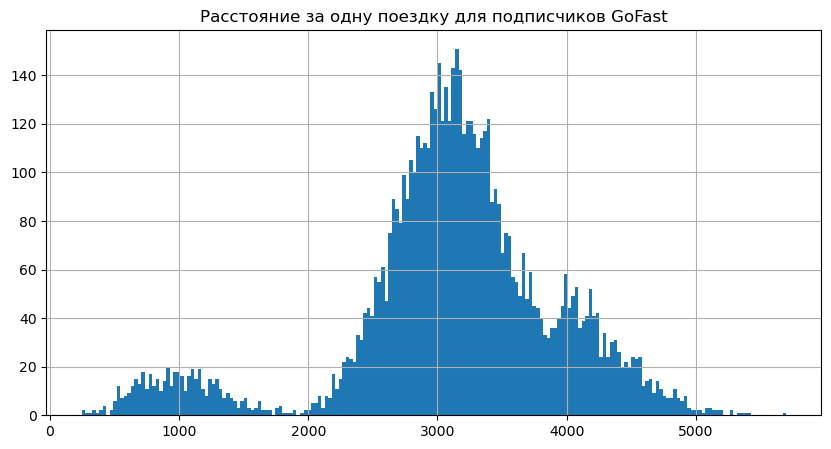

In [19]:
# Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий
# Начнем с пользователей с подпиской

display(subs_data['distance'].describe())
subs_data['distance'].hist(bins = 200, figsize = (10, 5));
plt.title('Расстояние за одну поездку для подписчиков GoFast')
plt.show()

В среднем расстояние за одну поездку у пользователей с подпиской не изменилось, по сравнению с общим средним значением - 3 км  

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

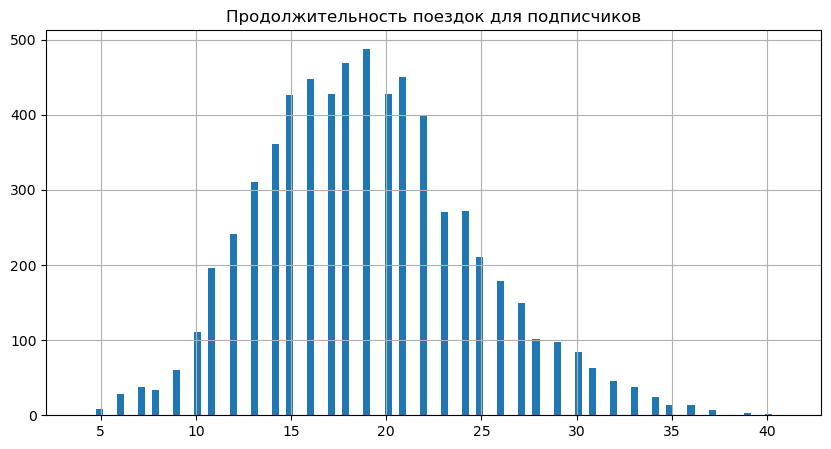

In [20]:
display(subs_data['duration'].describe())
subs_data['duration'].hist(bins = 100, figsize = (10, 5));
plt.title('Продолжительность поездок для подписчиков')
plt.show()

Продолжительность поездок у пользователей с подпиской в среднем составляет 19 минут

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

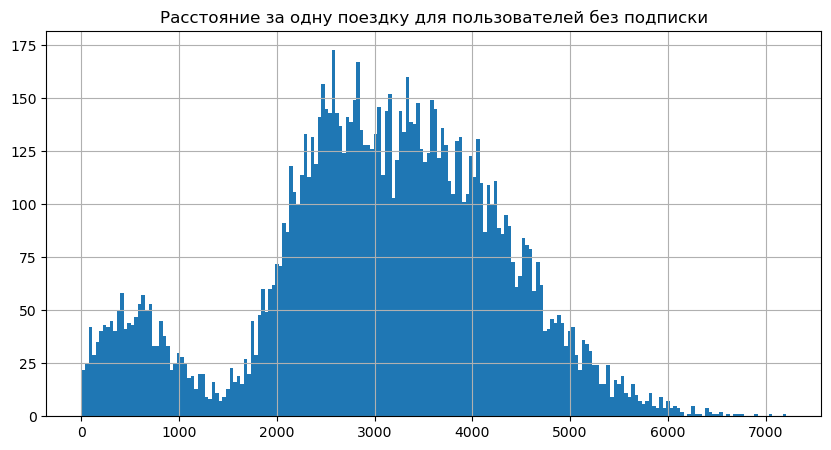

In [21]:
# Далее исследуем данные о пользователях без подписки

display(unsubs_data['distance'].describe())
unsubs_data['distance'].hist(bins = 200, figsize = (10, 5));
plt.title('Расстояние за одну поездку для пользователей без подписки')
plt.show()

Среднее расстояние, которое проезжает пользователь без подписки, составляет 3 км. То же значение, что и у пользователей-подписчиков. 

count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

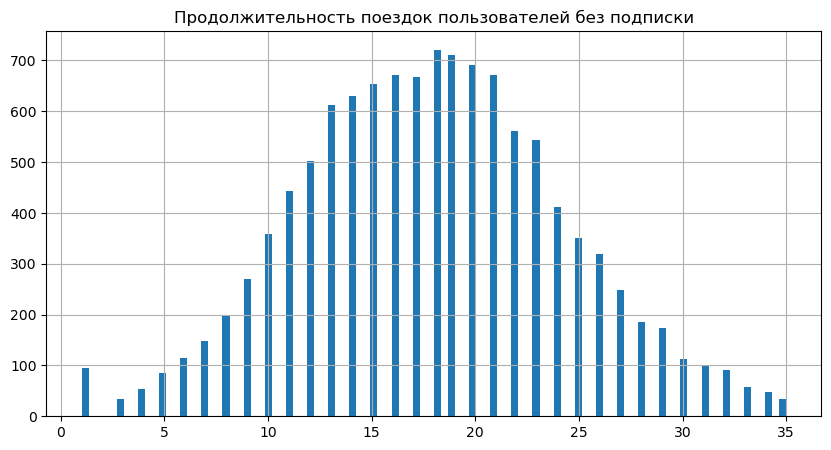

In [22]:
display(unsubs_data['duration'].describe())
unsubs_data['duration'].hist(bins = 100, figsize = (10, 5));
plt.title('Продолжительность поездок пользователей без подписки')
plt.show()

Средняя продолжительность поездок пользователей без подписки составляет 17 минут. Это на две минуты меньше, чем у подписчиков GoFast. 

В результате визуализации информации для пользователей обеих категорий, можно сделать вывод о том, что расстояние одной поездки в среднем одинаковое для пользователей обеих категорий, а среднее время поездки у пользователей без подписки немного меньше (на две минуты). 

#### Шаг 5. Подсчёт выручки

In [23]:
# Создаем датафрейм с агрегированными данными о поездках

agg_data = data.pivot_table(index = ['user_id', 'month'],
                            values = ['distance','duration', 'minute_price', 'start_ride_price', 'subscription_type', 'subscription_fee'],
                            aggfunc = {'distance' : ['sum', 'count'],
                                      'duration' : 'sum',
                                      'minute_price' : 'max',
                                      'start_ride_price' : 'max',
                                      'subscription_type' : 'max',
                                      'subscription_fee' : 'max'}
                                      )

# Переименуем названия столбцов

agg_data.columns = ['rides_count', 'total_distance', 'total_duration', 'minute_price', 'start_ride_price', 'subscription_fee', 'subscription_type']
agg_data.head(10)

rides_count  total_distance  total_duration  minute_price  \
user_id month                                                              
1       1                2     7027.511294              42             6   
        4                1      754.159807               7             6   
        8                2     6723.470560              46             6   
        10               2     5809.911100              32             6   
        11               3     7003.499363              56             6   
        12               2     6751.629942              28             6   
2       3                3    10187.723006              63             6   
        4                2     6164.381824              40             6   
        6                1     3255.338202              14             6   
        7                2     6780.722964              48             6   

               start_ride_price  subscription_fee subscription_type  
user_id month                                                        
1       1                     0               199             ultra  
        4                     0               199             ultra  
        8                     0               199             ultra  
        10                    0               199             ultra  
        11                    0               199             ultra  
        12                    0               199             ultra  
2       3                     0               199             ultra  
        4                     0               199             ultra  
        6                     0               199             ultra  
        7                     0               199             ultra

In [24]:
# Добавим в новый датафрейм столбец с выручкой за месяц для каждого пользователя
# Напишем функцию для вычисления помесячной выручки

def income_calculate(x):
    income = (x['start_ride_price'] * x['rides_count']) +(x['minute_price'] * x['total_duration']) + x['subscription_fee']
    return (income)

# Применяем функцию к новому датафрейму

agg_data['monthly_income'] = agg_data.apply(income_calculate, axis = 1)
agg_data.head(10)

rides_count  total_distance  total_duration  minute_price  \
user_id month                                                              
1       1                2     7027.511294              42             6   
        4                1      754.159807               7             6   
        8                2     6723.470560              46             6   
        10               2     5809.911100              32             6   
        11               3     7003.499363              56             6   
        12               2     6751.629942              28             6   
2       3                3    10187.723006              63             6   
        4                2     6164.381824              40             6   
        6                1     3255.338202              14             6   
        7                2     6780.722964              48             6   

               start_ride_price  subscription_fee subscription_type  \
user_id month                                                         
1       1                     0               199             ultra   
        4                     0               199             ultra   
        8                     0               199             ultra   
        10                    0               199             ultra   
        11                    0               199             ultra   
        12                    0               199             ultra   
2       3                     0               199             ultra   
        4                     0               199             ultra   
        6                     0               199             ultra   
        7                     0               199             ultra   

               monthly_income  
user_id month                  
1       1                 451  
        4                 241  
        8                 475  
        10                391  
        11                535  
        12                367  
2       3                 577  
        4                 439  
        6                 283  
        7                 487

In [25]:
# Код ревьюера
agg_data.groupby('subscription_fee')['monthly_income'].mean()

subscription_fee
0      328.641365
199    362.792191
Name: monthly_income, dtype: float64

#### Шаг 6. Проверка гипотез

Проверим гипотезу о том, что пользователи с подпиской больше времени на поездки, чем пользователи без нее:

   - Нулевая гипотеза: пользователи с подпиской и пользователи без подписки тратят равное количество времени на поездки.

   - Альтернативная гипотеза: пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

In [26]:
alpha = 0.05

results = st.ttest_ind(subs_data['duration'], unsubs_data['duration'], alternative = 'greater')

print('p-значение:', results.pvalue)
print('p-value {:.2E}'.format(results.pvalue))

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 2.4959453720736625e-34
p-value 2.50E-34
Отвергаем нулевую гипотезу


Результат показал, что, скорее всего, платные подписчики GoFast катаются на самокатах дольше, чем обычные пользователи без подписки. 

Проверим следующую гипотезу о том, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м:

   - Нулевая гипотеза: расстояние, которое платные подписчики  проезжают за одну поездку, равно 3130 метров. 
   - Альтернативная гипотеза: расстояние, которое проезжают платные подписчики за одну поездку, больше 3130 метров. 

In [27]:
interested_distance = 3130
alpha = 0.05

results = st.ttest_1samp(subs_data['distance'], interested_distance, alternative = 'greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


Результат показал, что отвергнуть гипотезу о том, что расстояние, которое платные подписчики проезжают за одну поездку, равно 3130 метров, мы не можем. Логично предположить, что платные подписчики понимают, что на одну поездку в среднем они тратят меньше денег, поэтому могут себе позволить "прокатиться подальше" по сравнению с обычными пользователями, для которых установлена стоимость старта, а также повышенная стоимость одной минуты поездки. 

Проверим следующую гипотезу о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки:
    
   - Нулевая гипотеза: помесячная выручка от платных подписчиков равна помесячной выручке от пользователей без подписки. 
   - Альтернативная гипотеза: помесячная выручка от платных подписчиков выше помесячной выручки от пользователей без подписки.

In [28]:
# Для проверки гипотезы необходимо создать два датафрейма со значениями помесячной выручки от каждой категории пользователей

subs_data_income = agg_data[agg_data['subscription_fee'] == 199]
unsubs_data_income = agg_data[agg_data['subscription_fee'] == 0]

In [29]:
display(subs_data_income['monthly_income'].describe())
display(unsubs_data_income['monthly_income'].describe())

count    4533.000000
mean      362.792191
std        88.262737
min       223.000000
25%       301.000000
50%       337.000000
75%       409.000000
max       955.000000
Name: monthly_income, dtype: float64

count    6798.000000
mean      328.641365
std       183.868330
min        58.000000
25%       194.000000
50%       274.000000
75%       428.000000
max      1444.000000
Name: monthly_income, dtype: float64

In [30]:
# Приступаем к проверке гипотезы
alpha = 0.05
results = st.ttest_ind(subs_data_income['monthly_income'], unsubs_data_income['monthly_income'], alternative = 'greater')

print('p-значение:', results.pvalue)
print('p-value {:.2E}'.format(results.pvalue))

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 1.8850394384715216e-31
p-value 1.89E-31
Отвергаем нулевую гипотезу


Результат проверки показал, что, скорее всего, платные подписчики GoFast в месяц приносят больше дохода, чем пользователи без подписки. 

# Итоговый вывод

### В ходе выполнения проекта:

- Изучена общая информация о первичных данных: три набора данных, содержащих информацию о пользователях GoFast (их id, имя, возраст, город, тип подписки), их поездках (расстояние в метрах и продолжительность сессии в минутах), а также о подписках (тип, стоимость одной минуты поездки, стоимость начала поездки и стоимость ежемесячного платежа);

- В результате предобработки данных недостатки были выявлены и устранены, а значения в столбцах были приведены к необходимым типам данных. 

- Изучена информация о пользователях и поездках, на основании которой можно сделать следующие выводы:

   - Больше всего пользователей из Пятигорска;
   - Пользователей без подписки больше пользователей с подпиской всего на 8%;
   - Средний возраст пользователей - 25 лет;
   - Среднее расстояние, которое преодолевает пользователь за поездку, составляет 18 минут;
   - Продолжительность одной поездки в среднем равна 3 км; 
   
- Данные о пользователях, поездках и подписках были в один датафрейм. Далее из него были созданы два набора данных с информацие о пользователях с подпиской и без подписки, на основании изучения которых можно сделать следующие выводы:

   - Расстояние одной поездки в среднем одинаковое для пользователей обеих категорий;
   - Среднее время поездки у пользователей без подписки немного меньше (на две минуты);

- Данные о поездках были агрегированны для формирования набора данных, содержащего информацию о суммарном расстоянии, количестве поездок и времени для каждого пользователя за каждый месяц. 
- На основании полученных данных подсчитан объем помесячной выручки, которую принёс каждый пользователь.

- Проведена проверка следующих гипотез:
   1. Тратят ли пользователи с подпиской больше времени на поездки?
   2. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
   3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

- Результат проверки гипотез:
    1. Платные подписчики GoFast катаются на самокатах дольше, чем обычные пользователи без подписки. 
    2. Мы не можем отвергнуть гипотезу о том, что расстояние, которое платные подписчики проезжают за одну поездку, равно 3130 метров.
    3. Платные подписчики GoFast в месяц приносят больше дохода, чем пользователи без подписки.

##### На основании проведенного исследования и проверки гипотез, можно сделать вывод о том, что платные подписчики GoFast являются более выгодными для компании, поскольку они приносят больше ежемесячной прибыли по сравнению с обычными пользователями.